# Penn Medicine COVID-19 Equity Data

Before importing Covid-19 patient data, we divide the variable "PT_ZIP" by "-"  
ie: divide 19104-3417 into two columns 19104 and 3417.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import mapclassify as mc
from geopandas import GeoDataFrame
%matplotlib inline

In [2]:
# Read Penn Medicine COVID-19 Equity Data.
CovidCases = pd.read_csv('/Users/zixiliu/Downloads/PENN-COVID/covid0622.csv')
# Read Philadelphia Zip Codes.
Philadelphia_Zips = [19102,19103,19104,19106,19107,19109,19110,19111,19112,19113,19114,19115,19116,19118,19119,19120,19121,19122,19123,19124,19125,19126,19127,19128,19129,19130,19131,19132,19133,19134,19135,19136,19137,19138,19139,19140,19141,19142,19143,19144,19145,19146,19147,19148,19149,19150,19151,19152,19153,19154]
# Select COVID cases in Philadelphia.
PhiladelphiaCases = CovidCases.loc[CovidCases['PT_ZIP'].isin(Philadelphia_Zips)]


In [3]:
# Group positive cases by zip codes
PhiCasesByZip = PhiladelphiaCases.groupby('PT_ZIP').aggregate({'PAT_ID':'count'})
PhiCasesByZip = PhiCasesByZip.reset_index().rename(columns={'PAT_ID': 'Count'})

#Append zip codes that have 0 positive cases
for i in Philadelphia_Zips:
        if i not in list(PhiCasesByZip['PT_ZIP']):
            PhiCasesByZip = PhiCasesByZip.append({'PT_ZIP': i, 'Count':0}, ignore_index = True) 

In [4]:
# Read US Zip Codes and Polygons
USZIPS = gpd.read_file("/Users/zixiliu/Downloads/uszip/tl_2019_us_zcta510.shp")
USZIPS['GEOID10'] = USZIPS['GEOID10'].astype(int)
# Merge Philadelphia COVID-19 Cases by Zip Codes with Polygon Geometries
PhiCasesMerged = pd.merge(PhiCasesByZip, USZIPS, how = "inner",left_on='PT_ZIP', right_on='GEOID10')

In [5]:
# Convert Data Frame to Geo Data Frame.
# Implement this step only if you want create maps in software QGIS/ArcGIS etc.
# Use the same code when you want to save Geo Data Frame as geojson.
PhiCasesGeo = GeoDataFrame(PhiCasesMerged)
PhiCasesGeo.to_file("/Users/zixiliu/Downloads/PENN-COVID/PhiCasesMerged0622.geojson", driver="GeoJSON")

## Philadelphia Positive Cases Map

/Users/zixiliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


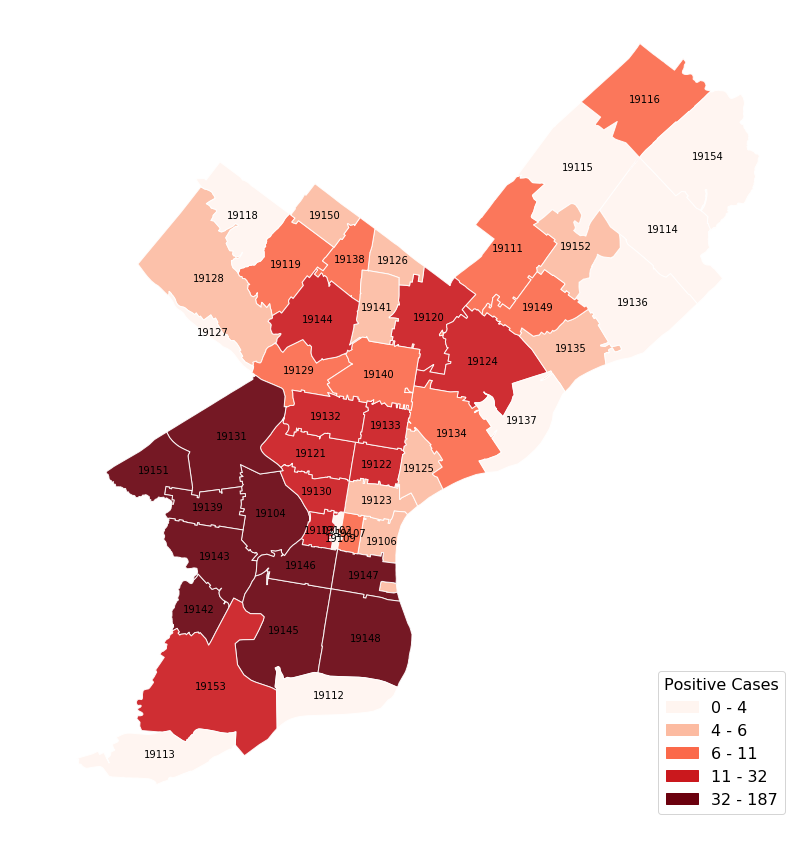

In [6]:
#Create Positive Cases Map with Geopandas
PhiCasesGeo = GeoDataFrame(PhiCasesMerged)
PhiCasesGeo.plot(figsize=(15,15),linewidth=1, edgecolor='white', column='Count',cmap = "Reds",scheme='quantiles',alpha = 0.9, legend=True)

for index,row in PhiCasesGeo.iterrows():
    xy=row['geometry'].centroid.coords[:]
    xytext=row['geometry'].centroid.coords[:]
    plt.annotate(row['PT_ZIP'],xy=xy[0], xytext=xytext[0],  horizontalalignment='center',verticalalignment='center')
    plt.axis('off')
    
#create legend labels after you read the quantiles 
cmap = cm.get_cmap('Reds')
first_patch = mpatches.Patch(color=cmap(0.0), label='0 - 4')
second_patch = mpatches.Patch(color=cmap(0.25), label='4 - 6')
third_patch = mpatches.Patch(color=cmap(0.5), label='6 - 11')
fourth_patch = mpatches.Patch(color=cmap(0.75), label='11 - 32')
fifth_patch = mpatches.Patch(color=cmap(0.99), label='32 - 187')
legend = plt.legend(handles=[first_patch, second_patch, third_patch, fourth_patch, fifth_patch],title="Positive Cases", fontsize = '16',loc='lower right')
legend.get_title().set_fontsize('16')

#Save the map
#plt.savefig('/Users/zixiliu/Downloads/PENN-COVID/PhiCasesMerged0622.png', dpi = 500)
plt.show()


In [7]:
#Define mortality in Philadelphia cases
def mor(n): 
    if (n == "Expired"):
        return 1
    elif (n in [np.nan]):
        return np.nan
    else :
        return 0

PhiladelphiaCases['Mortality'] = PhiladelphiaCases['EPT_DC_DISPOSITION'].apply(mor)

/Users/zixiliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# Group Data by Zip Codes and Mortality and count
PhiladelphiaMor = PhiladelphiaCases.groupby(['PT_ZIP','Mortality']).aggregate({'PAT_ID':'count'})
PhiMorByZip = PhiladelphiaMor.reset_index().rename(columns={'PAT_ID': 'Count'})
PhiMorByZip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
PT_ZIP       70 non-null int64
Mortality    70 non-null float64
Count        70 non-null int64
dtypes: float64(1), int64(2)
memory usage: 1.7 KB


In [9]:
# Check Missing Data for Zip Codes and Mortality
for i in Philadelphia_Zips:
        if i not in list(PhiMorByZip['PT_ZIP']):
            PhiMorByZip = PhiMorByZip.append({'PT_ZIP': i, 'Mortality': 0, 'Count':0}, ignore_index = True)
            PhiMorByZip = PhiMorByZip.append({'PT_ZIP': i, 'Mortality': 1, 'Count':0}, ignore_index = True) 
        elif i in list(PhiCasesByZip['PT_ZIP']):
            if len(PhiMorByZip[PhiMorByZip['PT_ZIP'] == i]) != 2:
                if PhiMorByZip[PhiMorByZip['PT_ZIP'] == i]['Mortality'].iloc[0] == 0:
                    PhiMorByZip = PhiMorByZip.append({'PT_ZIP': i, 'Mortality': 1, 'Count':0}, ignore_index = True)
                elif PhiMorByZip[PhiMorByZip['PT_ZIP'] == i]['Mortality'].iloc[0] == 1:
                    PhiMorByZip = PhiMorByZip.append({'PT_ZIP': i, 'Mortality': 0, 'Count':0}, ignore_index = True)
            

In [10]:
# Compute Mortality Rate for each Zip Code and fillna
PhiCases2 = PhiMorByZip.groupby(['PT_ZIP']).sum().reset_index().rename(columns={'Count': 'TotalCount'})
PhiMor = PhiMorByZip[PhiMorByZip['Mortality']==1].rename(columns={'Count': 'MorCount'})
PhiMorRate = pd.merge(PhiCases2, PhiMor, on ="PT_ZIP")
PhiMorRate['MorRate'] = PhiMorRate['MorCount'] / PhiMorRate['TotalCount']
PhiMorRate['MorRate'].fillna(0, inplace=True)

## Philadelphia Mortality Rate Map

/Users/zixiliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/zixiliu/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/zixiliu/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


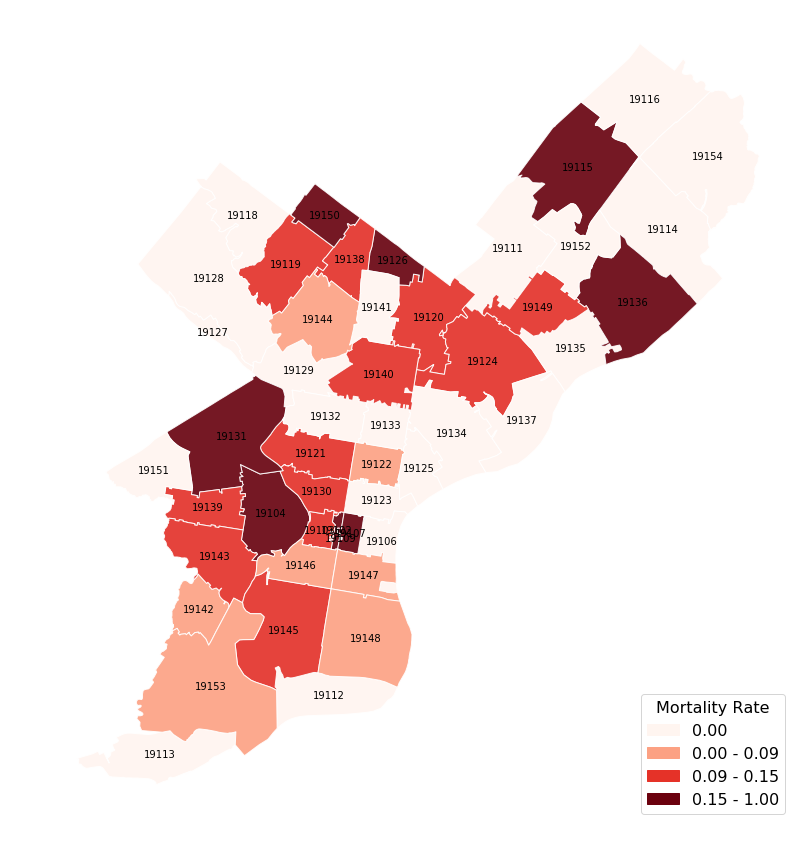

In [11]:
PhiMorMerged = pd.merge(PhiMorRate, USZIPS, how = "inner",left_on='PT_ZIP', right_on='GEOID10')
PhiMorGeo = GeoDataFrame(PhiMorMerged)

PhiMorGeo.plot(figsize=(15,15),linewidth=1, edgecolor='white', column='MorRate',cmap='Reds',scheme='QUANTILES', alpha = 0.9, legend=True)

for index,row in PhiMorGeo.iterrows():
    xy=row['geometry'].centroid.coords[:]
    xytext=row['geometry'].centroid.coords[:]
    plt.annotate(row['PT_ZIP'],xy=xy[0], xytext=xytext[0],  horizontalalignment='center',verticalalignment='center')
    plt.axis('off')
    
#create legends
cmap = cm.get_cmap('Reds')
first_patch = mpatches.Patch(color=cmap(0.0), label='0.00')
second_patch = mpatches.Patch(color=cmap(0.33), label='0.00 - 0.09')
third_patch = mpatches.Patch(color=cmap(0.66), label='0.09 - 0.15')
fourth_patch = mpatches.Patch(color=cmap(0.99), label='0.15 - 1.00')
legend = plt.legend(handles=[first_patch, second_patch, third_patch, fourth_patch],title="Mortality Rate", fontsize = '16',loc='lower right')
legend.get_title().set_fontsize('16')

#Save the map
#plt.savefig('/Users/zixiliu/Downloads/PENN-COVID/PhiMorMerged0622.png', dpi = 500)
plt.show()

## Chester County Positive Cases Map

In [12]:
# Read Chester County Zip Codes.
Chester_Zips = [17527, 17555, 19073, 19087, 19301, 19310, 19311, 19312, 19317, 19319, 19320, 19330, 19333, 19335, 19341, 19342, 19343, 19344, 19348, 19350, 19352, 19355, 19362, 19363, 19365, 19372, 19374, 19380, 19382, 19390, 19425, 19460, 19465, 19475, 19520, 19543]
# Select COVID cases in Chester County.
ChesterCases = CovidCases.loc[CovidCases['PT_ZIP'].isin(Chester_Zips)]

# Group positive cases by zip codes
ChesterCasesByZip = ChesterCases.groupby('PT_ZIP').aggregate({'PAT_ID':'count'})
ChesterCasesByZip = ChesterCasesByZip.reset_index().rename(columns={'PAT_ID': 'Count'})

#Append zip codes that have 0 positive cases
for i in Chester_Zips:
        if i not in list(ChesterCasesByZip['PT_ZIP']):
            ChesterCasesByZip = ChesterCasesByZip.append({'PT_ZIP': i, 'Count':0}, ignore_index = True) 

# Merge Philadelphia COVID-19 Cases by Zip Codes with Polygon Geometries
ChesterCasesMerged = pd.merge(ChesterCasesByZip, USZIPS, how = "inner",left_on='PT_ZIP', right_on='GEOID10')
               

/Users/zixiliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


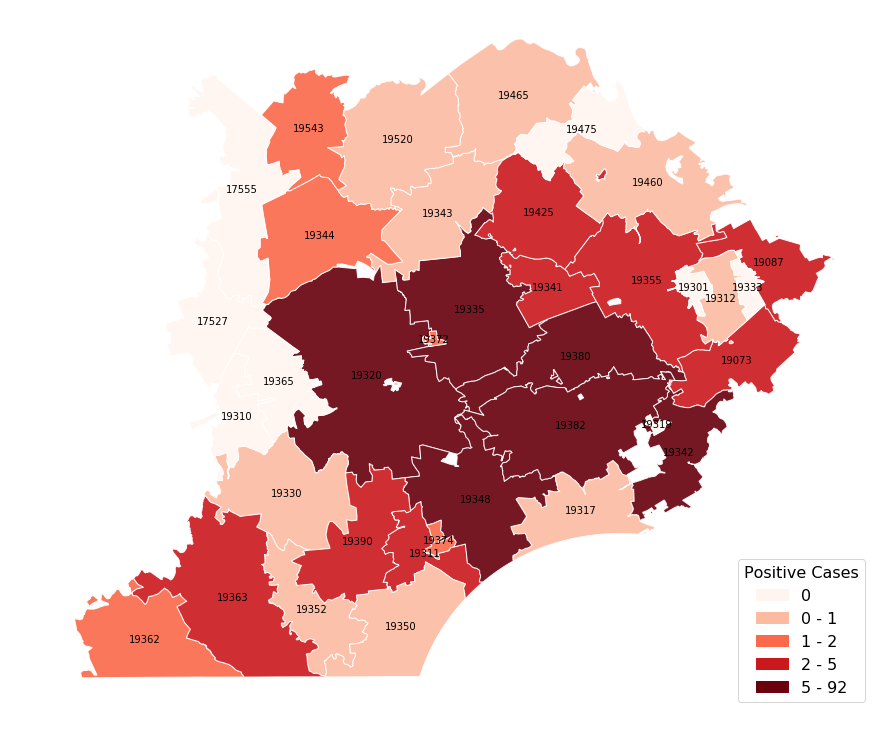

In [502]:
#Create Positive Cases Map with Geopandas
ChesterCasesGeo = GeoDataFrame(ChesterCasesMerged)
ChesterCasesGeo.plot(figsize=(15,15),linewidth=1, edgecolor='white', column='Count',cmap = "Reds",scheme='quantiles',alpha = 0.9, legend=True)

for index,row in ChesterCasesGeo.iterrows():
    xy=row['geometry'].centroid.coords[:]
    xytext=row['geometry'].centroid.coords[:]
    plt.annotate(row['PT_ZIP'],xy=xy[0], xytext=xytext[0],  horizontalalignment='center',verticalalignment='center')
    plt.axis('off')
    
#create legend labels after you read the quantiles 
cmap = cm.get_cmap('Reds')
first_patch = mpatches.Patch(color=cmap(0.0), label='0')
second_patch = mpatches.Patch(color=cmap(0.25), label='0 - 1')
third_patch = mpatches.Patch(color=cmap(0.5), label='1 - 2')
fourth_patch = mpatches.Patch(color=cmap(0.75), label='2 - 5')
fifth_patch = mpatches.Patch(color=cmap(0.99), label='5 - 92')
legend = plt.legend(handles=[first_patch, second_patch, third_patch, fourth_patch, fifth_patch],title="Positive Cases", fontsize = '16',loc='lower right')
legend.get_title().set_fontsize('16')

#Save the map
#plt.savefig('/Users/zixiliu/Downloads/PENN-COVID/ChesterCasesMerged0622.png', dpi = 500)
plt.show()


## Chester County Mortality Rate Map

In [13]:
#Define mortality in Philadelphia cases
def mor(n): 
    if (n == "Expired"):
        return 1
    elif (n in [np.nan]):
        return np.nan
    else :
        return 0

ChesterCases['Mortality'] = ChesterCases['EPT_DC_DISPOSITION'].apply(mor)

# Group Data by Zip Codes and Mortality and count
ChesterMor = ChesterCases.groupby(['PT_ZIP','Mortality']).aggregate({'PAT_ID':'count'})
ChesterMorByZip = ChesterMor.reset_index().rename(columns={'PAT_ID': 'Count'})
ChesterMorByZip.info()

# Check Missing Data for Zip Codes and Mortality
for i in Chester_Zips:
        if i not in list(ChesterMorByZip['PT_ZIP']):
            ChesterMorByZip = ChesterMorByZip.append({'PT_ZIP': i, 'Mortality': 0, 'Count':0}, ignore_index = True)
            ChesterMorByZip = ChesterMorByZip.append({'PT_ZIP': i, 'Mortality': 1, 'Count':0}, ignore_index = True) 
        elif i in list(ChesterCasesByZip['PT_ZIP']):
            if len(ChesterMorByZip[ChesterMorByZip['PT_ZIP'] == i]) != 2:
                if ChesterMorByZip[ChesterMorByZip['PT_ZIP'] == i]['Mortality'].iloc[0] == 0:
                    ChesterMorByZip = ChesterMorByZip.append({'PT_ZIP': i, 'Mortality': 1, 'Count':0}, ignore_index = True)
                elif ChesterMorByZip[ChesterMorByZip['PT_ZIP'] == i]['Mortality'].iloc[0] == 1:
                    ChesterMorByZip = ChesterMorByZip.append({'PT_ZIP': i, 'Mortality': 0, 'Count':0}, ignore_index = True)

# Compute Mortality Rate for each Zip Code and fillna
ChesterCases2 = ChesterMorByZip.groupby(['PT_ZIP']).sum().reset_index().rename(columns={'Count': 'TotalCount'})
ChesterMor = ChesterMorByZip[ChesterMorByZip['Mortality']==1].rename(columns={'Count': 'MorCount'})
ChesterMorRate = pd.merge(ChesterCases2, ChesterMor, on ="PT_ZIP")
ChesterMorRate['MorRate'] = ChesterMorRate['MorCount'] / ChesterMorRate['TotalCount']
ChesterMorRate['MorRate'].fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
PT_ZIP       41 non-null int64
Mortality    41 non-null float64
Count        41 non-null int64
dtypes: float64(1), int64(2)
memory usage: 1.0 KB


/Users/zixiliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


/Users/zixiliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/zixiliu/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/zixiliu/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


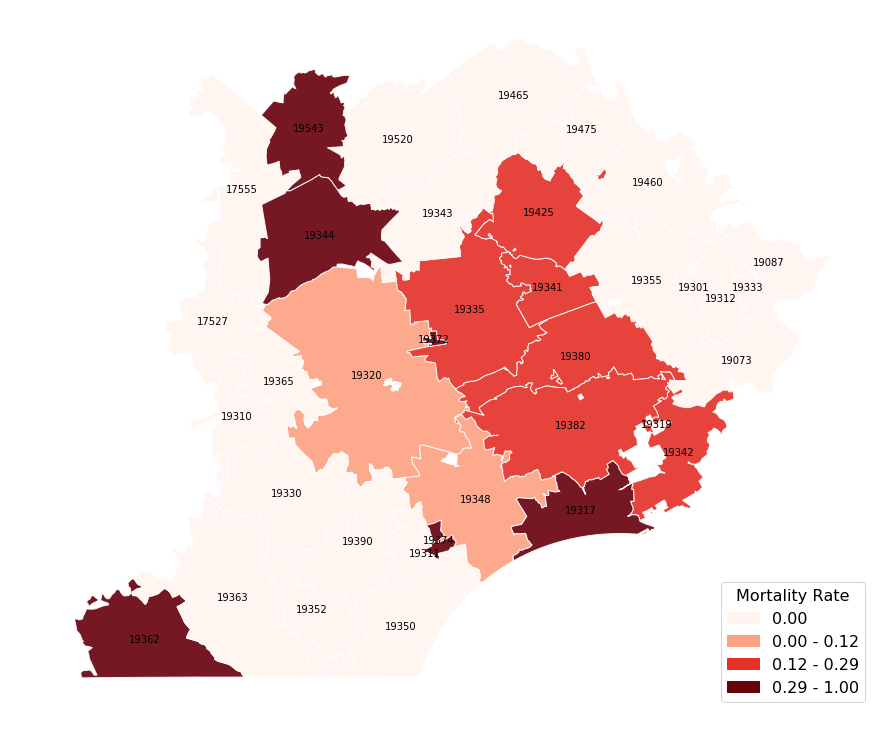

In [14]:
ChesterMorMerged = pd.merge(ChesterMorRate, USZIPS, how = "inner",left_on='PT_ZIP', right_on='GEOID10')
ChesterMorGeo = GeoDataFrame(ChesterMorMerged)

ChesterMorGeo.plot(figsize=(15,15),linewidth=1, edgecolor='white', column='MorRate',cmap='Reds',scheme='QUANTILES',k=6, alpha = 0.9, legend=True)

for index,row in ChesterMorGeo.iterrows():
    xy=row['geometry'].centroid.coords[:]
    xytext=row['geometry'].centroid.coords[:]
    plt.annotate(row['PT_ZIP'],xy=xy[0], xytext=xytext[0],  horizontalalignment='center',verticalalignment='center')
    plt.axis('off')
    
#create legends
cmap = cm.get_cmap('Reds')
first_patch = mpatches.Patch(color=cmap(0.0), label='0.00')
second_patch = mpatches.Patch(color=cmap(0.33), label='0.00 - 0.12')
third_patch = mpatches.Patch(color=cmap(0.66), label='0.12 - 0.29')
fourth_patch = mpatches.Patch(color=cmap(0.99), label='0.29 - 1.00')
legend = plt.legend(handles=[first_patch, second_patch, third_patch, fourth_patch],title="Mortality Rate", fontsize = '16',loc='lower right')
legend.get_title().set_fontsize('16')

#Save the map
#plt.savefig('/Users/zixiliu/Downloads/PENN-COVID/ChesterMorMerged0622.png', dpi = 500)
plt.show()